In [7]:
pip install llama-index llama-index-llms-groq llama-index-embeddings-huggingface sentence-transformers

In [8]:
pip install groq

In [10]:
pip show pinecone

Name: pinecone
Version: 7.0.2
Summary: Pinecone client and SDK
Home-page: https://www.pinecone.io
Author: Pinecone Systems, Inc.
Author-email: support@pinecone.io
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: certifi, pinecone-plugin-assistant, pinecone-plugin-interface, python-dateutil, typing-extensions, urllib3
Required-by: 


In [2]:
%pip uninstall pinecone-client -y

Found existing installation: pinecone-client 6.0.0
Uninstalling pinecone-client-6.0.0:
  Successfully uninstalled pinecone-client-6.0.0


In [3]:
%pip install pinecone==3.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.9/199.9 kB 12.7 MB/s eta 0:00:00


In [5]:
import os
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.llms.groq import Groq
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from pinecone import Pinecone, ServerlessSpec

# Set Groq API key (replace with your actual key)

In [ ]:

os.environ["GROQ_API_KEY"] = "api"
pc = Pinecone(api_key="api")

# Initialize Pinecone for LTM

In [ ]:

index_name = "llamaindex-legal-docs"
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
pinecone_index = pc.Index(index_name)  
pine= pc.Pinecone(index_name=index_name, 
                  embedding=HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2"),
                  llm=Groq(model_name="groq/groq-llama-3-70b-instruct"),
                  vector_store=pinecone_index)

# Load sample legal documents(For RAG activation)

In [16]:

with open("tax_law_2023.txt", "w") as f:
    f.write("2023 Tax Law Case: Key points include updated deductions, increased tax credits for low-income households, and new compliance requirements.")
documents = SimpleDirectoryReader(input_files=["tax_law_2023.txt"]).load_data()



# Set up LLM and embeddings

In [17]:
llm = Groq(model="llama-3.3-70b-versatile")
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
Settings.llm = llm
Settings.embed_model = embed_model


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Create vector store index

In [24]:

index = VectorStoreIndex.from_documents(documents)

# Set up memory
memory = ChatMemoryBuffer.from_defaults(token_limit=512)


# Create metadata for the tool

In [29]:
%pip install llama-index-tools-duckduckgo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.5 MB/s eta 0:00:00


In [33]:
from llama_index.core.tools import QueryEngineTool, ToolMetadata


tool_metadata = ToolMetadata(
    name="legal_query_tool",
    description="Query 2023 tax law documents"
)

# Create a tool from the query engine using QueryEngineTool and provide metadata
query_engine_tool = QueryEngineTool(
    query_engine=query_engine,
    metadata=tool_metadata
)

# Define LlamaIndex agent with the created tool
from llama_index.core.agent import ReActAgent
agent = ReActAgent.from_tools(
    tools=[query_engine_tool],  # Pass the created tool here
    llm=llm,
    memory=memory,
    verbose=True
)


# Run LlamaIndex agent

In [34]:

response = agent.chat("What are key points of 2023 tax law case? of pakistan ??")
print("LlamaIndex Response:", response)




> Running step b48d26ee-c843-41de-8770-222bd6716e28. Step input: What are key points of 2023 tax law case? of pakistan ??
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: legal_query_tool
Action Input: {'input': '2023 tax law case of Pakistan'}
Observation: Information about the 2023 tax law case of a specific country is not provided. The available information only mentions the 2023 Tax Law Case with key points including updated deductions, increased tax credits for low-income households, and new compliance requirements, without specifying the country.
> Running step fff719da-a9a2-4cb6-965e-ebd0f823c56b. Step input: None
Thought: The tool output does not provide the required information about the 2023 tax law case of Pakistan. I should try to find more general information about tax law.
Action: legal_query_tool
Action Input: {'input': 'Pakistan tax law 2023'}
Observation: 2023 Tax Law includes updated deductions, increa

# === Mermaid Diagram for LlamaIndex Workflow ===


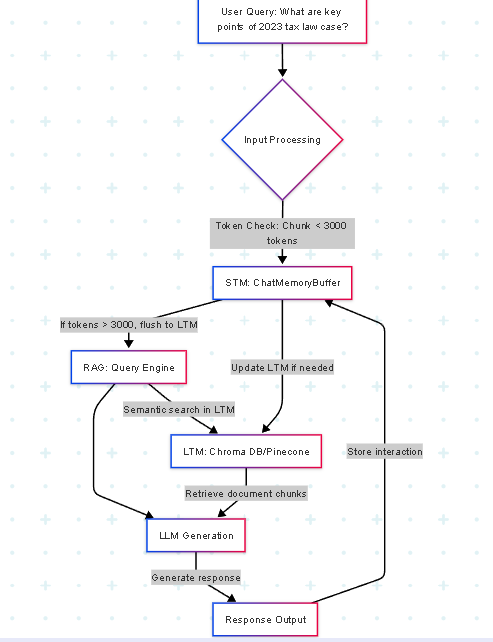